In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# tomar n elementos de una secuencia
from itertools import islice as take

import matplotlib.pyplot as plt
from utilities3 import *
from utils import *

import operator
from functools import reduce
from functools import partial

import scipy.io
# barras de progreso
from tqdm import trange

torch.manual_seed(0)
np.random.seed(0)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Índice

- [Arquitectura](#Definiendo-arquitectura)
- [Final](#Final)

## Definiendo arquitectura

### Operaciones en el espacio de Fourier de la capa de Fourier

In [3]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                                             self.modes3, dtype=torch.cfloat))
        
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                                             self.modes3, dtype=torch.cfloat))
        
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                                             self.modes3, dtype=torch.cfloat))
        
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 
                                                             self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, inp, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", inp, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 
                             dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

### Capa de Fourier

In [36]:
class FourierLayerBlock(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FourierLayerBlock, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        
        self.rama_superior = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.rama_inferior = nn.Conv1d(self.width, self.width, 1)
        
    def forward(self, x, batchsize, size_x, size_y, size_z):        
        x_sup = self.rama_superior(x)
        x_inf = self.rama_inferior(x.view(batchsize, self.width, -1)).view(batchsize, 
                                                                           self.width, size_x, size_y, size_z)
        x = x_sup + x_inf
        x = F.relu(x)
        return x

### Operador neuronal de Fourier

In [37]:
class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width, layers = 4):
        super(FNO3d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.layers = layers
        
        self.fc0 = nn.Linear(13, self.width)

        self.module = nn.ModuleList()
        for idx in range(self.layers):
            fl = FourierLayerBlock(self.modes1, self.modes2, self.modes3, self.width)
            self.module.append(fl)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        # P
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        # Las capas de Fourier
        for mod in self.module:
            x = mod(x, batchsize, size_x, size_y, size_z)
        # Q
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Configuraciones

In [63]:
#PATH = 'datasets/NavierStokes/NavierStokes_V1e-5_N1200_T20.mat'
PATH = "datasets/NavierStokes/ns_data_V1e-4_N20_T200_R256test.mat"

ntrain = 1000
ntest = 200

modes = 6 # Esto alguna vez fue 8
width = 20

batch_size = 10

learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.05

sub = 1
S = 64 // sub
T_in = 10
T = 20 - T_in

## Instanciando un modelo

In [60]:
model = FNO3d(modes, modes, modes, width)
print(model)

FNO3d(
  (fc0): Linear(in_features=13, out_features=10, bias=True)
  (module): ModuleList(
    (0): FourierLayerBlock(
      (rama_superior): SpectralConv3d()
      (rama_inferior): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
    )
    (1): FourierLayerBlock(
      (rama_superior): SpectralConv3d()
      (rama_inferior): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
    )
    (2): FourierLayerBlock(
      (rama_superior): SpectralConv3d()
      (rama_inferior): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
    )
    (3): FourierLayerBlock(
      (rama_superior): SpectralConv3d()
      (rama_inferior): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
    )
  )
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


## Cargando datos

In [8]:
dataloader = MatReader(PATH)
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

ntrain = int(ntrain*0.8)
neval = int(ntrain*0.2)

# Conjunto de entrenamiento
x_train = x_train[:ntrain,:]
y_train = y_train[:ntrain,:]
# Conjunto de evaluación
x_eval = x_train[-neval:,:]
y_eval = y_train[-neval:,:]

reader = MatReader(PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in] # [ejemplo, alto, ancho, tiempo]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:(T+T_in)]

eval_a = reader.read_field('u')[ntrain:(ntrain+neval),::sub,::sub,:T_in] # [ejemplo, alto, ancho, tiempo]
eval_u = reader.read_field('u')[ntrain:(ntrain+neval),::sub,::sub,T_in:(T+T_in)]

test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:(T+T_in)]

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
eval_a = eval_a.reshape(neval,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
eval_a = torch.cat((gridx.repeat([neval,1,1,1,1]), gridy.repeat([neval,1,1,1,1]),
                       gridt.repeat([neval,1,1,1,1]), eval_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1]),
                       gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), 
                                           batch_size=batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(eval_a, eval_u), 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), 
                                          batch_size=batch_size, shuffle=False)

In [79]:
#PATH = 'datasets/NavierStokes/NavierStokes_V1e-5_N1200_T20.mat'
PATH2 = "datasets/NavierStokes/ns_data_V1e-4_N20_T200_R256test.mat"

modes = 6 # Esto alguna vez fue 8
width = 20

batch_size = 10

learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.05

sub2 = 4
S2 = 256 // sub2
T2 = 10


reader2 = MatReader(PATH)
a = reader2.read_field('u')[:20,:,:,:10] # [ejemplo, alto, ancho, tiempo]
u = reader2.read_field('u')[:20,:,:,10:20]

a = a.reshape(20,S2,S2,1,10).repeat([1,1,1,10,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S2), dtype=torch.float)
gridx = gridx.reshape(1, S2, 1, 1, 1).repeat([1, 1, S2, T2, 1])
gridy = torch.tensor(np.linspace(0, 1, S2), dtype=torch.float)
gridy = gridy.reshape(1, 1, S2, 1, 1).repeat([1, S, 1, T2, 1])
gridt = torch.tensor(np.linspace(0, 1, T2+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T2, 1).repeat([1, S2, S2, 1, 1])

a = torch.cat((gridx.repeat([20,1,1,1,1]), gridy.repeat([20,1,1,1,1]),
                       gridt.repeat([20,1,1,1,1]), a), dim=-1)



a_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a, u), 
                                           batch_size=batch_size, shuffle=True)

## Entrenamiento y evaluación

In [64]:
def train_epoch_GPU(dl, model, opt, scheduler):
    myloss = LpLoss(size_average=False)
    # Entrenamos por cada lote
    for x, y in dl:
        out = model(x.to(device)).view(batch_size, S, S, T)
        # Computamos la pérdida
        mse = F.mse_loss(out.view(batch_size, -1), y.to(device).view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.to(device).view(batch_size, -1))
        
        # Vaciamos los gradientes
        opt.zero_grad()
        
        # Retropropagamos
        l2.backward() # l2 pérdida relativa

        opt.step()
        
    scheduler.step()
    model.eval()
        
def eval_epoch_GPU(dl, model, num_batches=None):
    myloss = LpLoss(size_average=False)
    # Evitamos que se registren las operaciones en la gráfica de cómputo
    with torch.no_grad():
        # historiales
        losses, mses = [], []

        # validación de la época con num_batches
        test_l2 = 0
        for x, y_true in take(dl, num_batches):
            out = model(x.to(device)).view(batch_size, S, S, T)

            test_l2 = myloss(out.view(1, -1), y_true.to(device).view(1, -1)).item()
            test_mse = F.mse_loss(out.view(1, -1), y_true.to(device).view(1, -1), reduction='mean')
            losses.append(test_l2)
            mses.append(test_mse.cpu())
        # promediamos
        loss = np.mean(losses)
        mse = np.mean(mses)

        return loss, mse
        
        
def train_GPU(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
              trn_batches=None, tst_batches=None):
    myloss = LpLoss(size_average=False)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=scheduler_step, gamma=scheduler_gamma)
    
    loss_hist, mse_hist = [], []
    for epoch in trange(epochs):
        # entrenamos la época
        train_epoch_GPU(trn_dl, model, opt, scheduler)
        
        # evaluamos la época en entrenamiento
        trn_loss, trn_mse = eval_epoch_GPU(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_mse = eval_epoch_GPU(tst_dl, model, tst_batches)
        
        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        mse_hist.append([trn_mse, tst_mse])
        
        # imprimimos progreso
        print(f'E{epoch:02} \n'
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] \n'
              f'mse=[{trn_mse:6.2f},{tst_mse:6.2f}] \n')
    return loss_hist, mse_hist

## Entrenando modelo

### 10 épocas

In [65]:
%%time
# instanciamos un modelo
model = FNO3d(modes, modes, modes, width)
# entrenamos
epochs = 10
loss_hist, mse_hist = train_GPU(model.to(device), train_loader, eval_loader, epochs=epochs,lr = learning_rate)

 10%|█         | 1/10 [00:07<01:07,  7.52s/it]

E00 
loss=[  0.51,  0.51] 
mse=[  0.55,  0.55] 



 20%|██        | 2/10 [00:17<01:12,  9.02s/it]

E01 
loss=[  0.36,  0.37] 
mse=[  0.28,  0.29] 



 30%|███       | 3/10 [00:25<00:58,  8.37s/it]

E02 
loss=[  0.32,  0.33] 
mse=[  0.22,  0.23] 



 40%|████      | 4/10 [00:32<00:48,  8.06s/it]

E03 
loss=[  0.31,  0.31] 
mse=[  0.20,  0.21] 



 50%|█████     | 5/10 [00:40<00:39,  7.89s/it]

E04 
loss=[  0.29,  0.30] 
mse=[  0.18,  0.19] 



 60%|██████    | 6/10 [00:48<00:32,  8.05s/it]

E05 
loss=[  0.27,  0.28] 
mse=[  0.16,  0.17] 



 70%|███████   | 7/10 [00:56<00:23,  7.99s/it]

E06 
loss=[  0.26,  0.27] 
mse=[  0.14,  0.16] 



 80%|████████  | 8/10 [01:04<00:16,  8.03s/it]

E07 
loss=[  0.25,  0.26] 
mse=[  0.13,  0.15] 



 90%|█████████ | 9/10 [01:12<00:08,  8.00s/it]

E08 
loss=[  0.24,  0.26] 
mse=[  0.12,  0.14] 



100%|██████████| 10/10 [01:20<00:00,  8.05s/it]

E09 
loss=[  0.23,  0.25] 
mse=[  0.11,  0.13] 

CPU times: user 5min 3s, sys: 279 ms, total: 5min 4s
Wall time: 1min 20s


In [53]:
path_model = f"modelos/NS_{epochs}epochs"
torch.save(model, path_model)

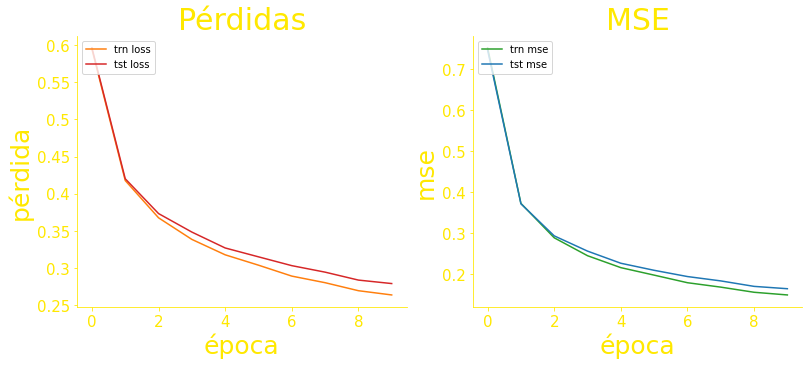

In [54]:
plot_metrics(loss_hist, mse_hist, epoch = epochs)#, name = f"metrics_{epochs}epochs_ns")

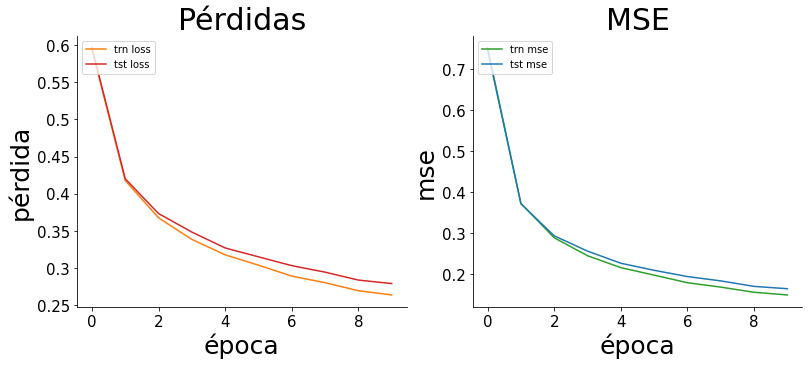

In [55]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, c = "k")#, name = f"metrics_{epochs}epochs_ns_black", c = "black")

[Ir a inicio](#Índice) 

## Evaluamos en entrenamiento

In [14]:
with torch.no_grad():
    preds = []
    y_trues = []
    for x, y_true in test_loader:
        out = model(x.to(device))
        y_trues.append(y_true)
        preds.append(out.squeeze().cpu())

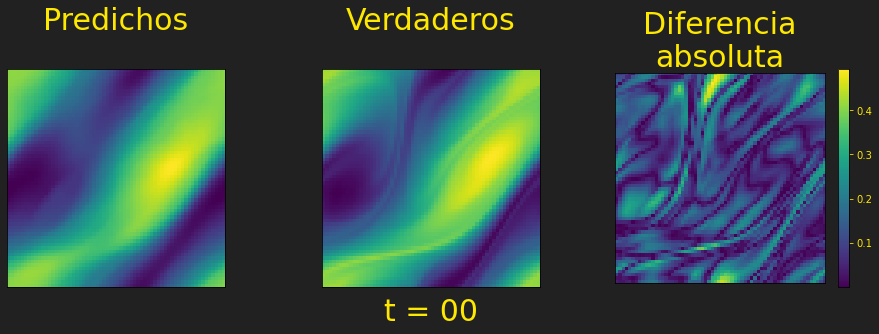

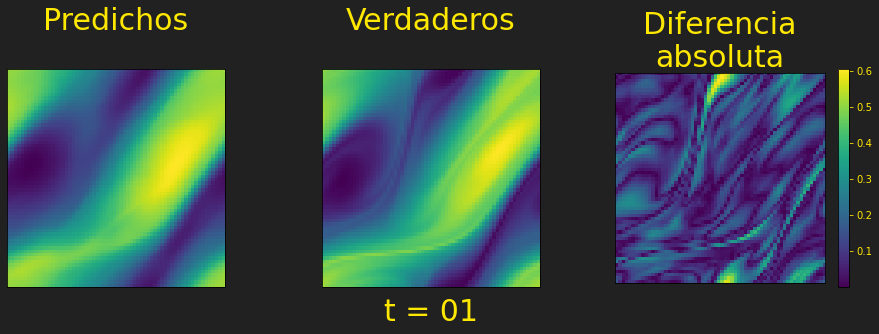

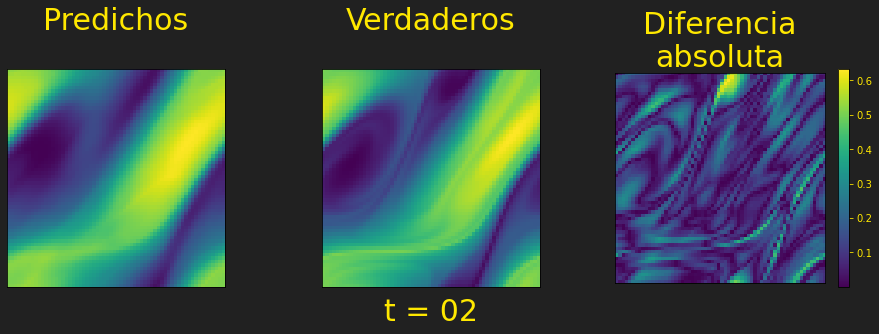

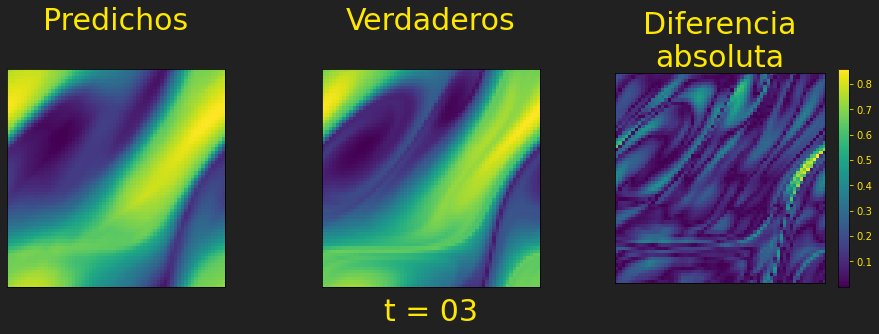

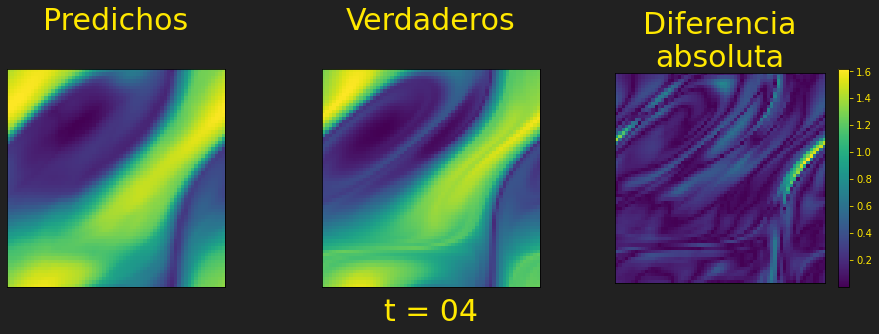

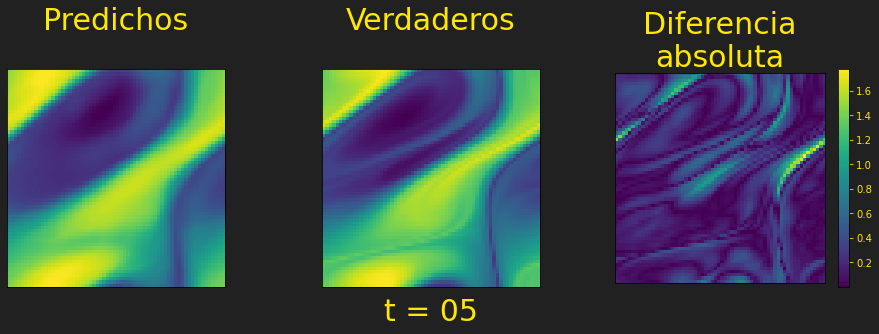

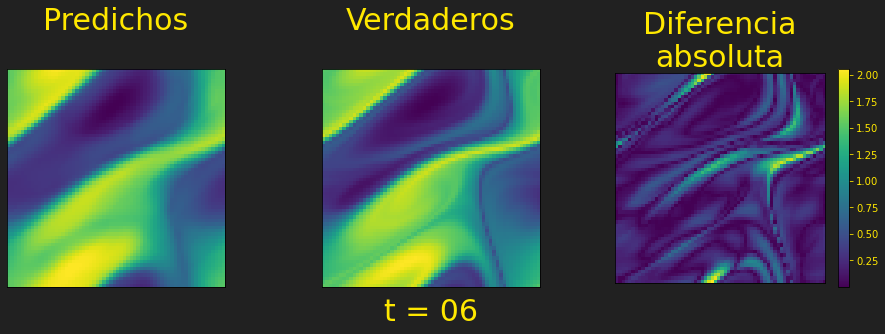

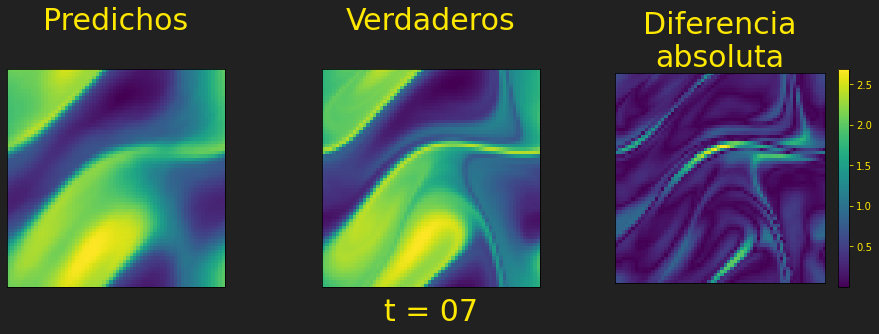

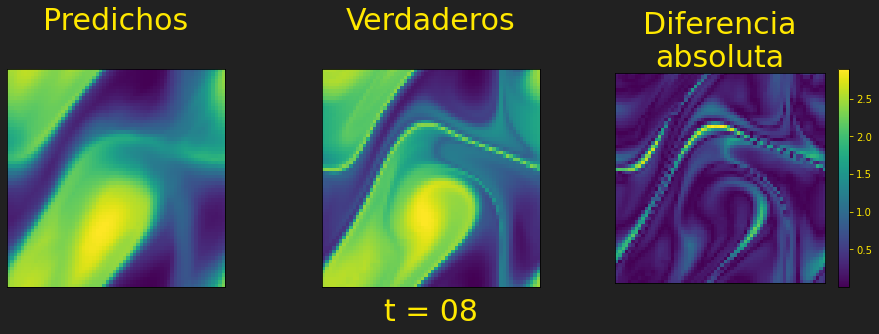

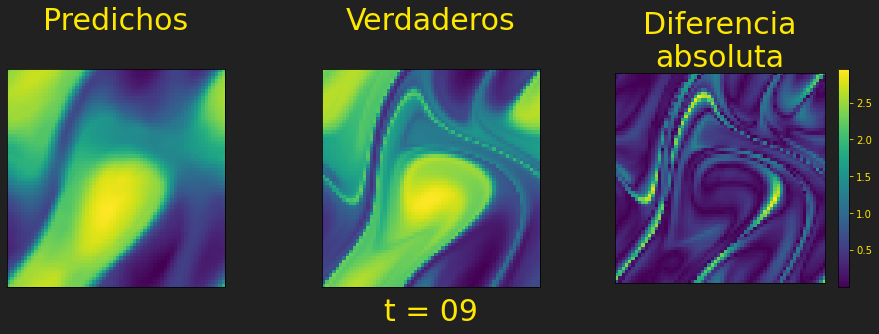

In [16]:
plot_many(preds[0][0,:,:,:], np.array(y_trues[0][0,:,:,:]), epochs)

In [17]:
create_gif(epochs)

### 100 épocas

In [18]:
%%time
# instanciamos un modelo
model = FNO3d(modes, modes, modes, width)
# entrenamos
epochs = 100
loss_hist, mse_hist = train_GPU(model.to(device), train_loader, eval_loader, epochs=epochs)

  1%|          | 1/100 [00:49<1:21:39, 49.49s/it]

E00 
loss=[  0.49,  0.50] 
mse=[  0.52,  0.52] 



  2%|▏         | 2/100 [01:01<45:06, 27.62s/it]  

E01 
loss=[  0.34,  0.35] 
mse=[  0.25,  0.26] 



  3%|▎         | 3/100 [01:14<33:23, 20.65s/it]

E02 
loss=[  0.30,  0.31] 
mse=[  0.20,  0.21] 



  4%|▍         | 4/100 [01:26<27:54, 17.44s/it]

E03 
loss=[  0.28,  0.29] 
mse=[  0.16,  0.18] 



  5%|▌         | 5/100 [01:39<24:46, 15.65s/it]

E04 
loss=[  0.26,  0.27] 
mse=[  0.14,  0.15] 



  6%|▌         | 6/100 [01:51<22:50, 14.58s/it]

E05 
loss=[  0.24,  0.26] 
mse=[  0.13,  0.14] 



  7%|▋         | 7/100 [02:04<21:40, 13.98s/it]

E06 
loss=[  0.23,  0.25] 
mse=[  0.11,  0.13] 



  8%|▊         | 8/100 [02:17<20:49, 13.59s/it]

E07 
loss=[  0.23,  0.25] 
mse=[  0.12,  0.13] 



  9%|▉         | 9/100 [02:29<20:12, 13.32s/it]

E08 
loss=[  0.22,  0.23] 
mse=[  0.10,  0.11] 



 10%|█         | 10/100 [02:42<19:44, 13.16s/it]

E09 
loss=[  0.21,  0.23] 
mse=[  0.09,  0.11] 



 11%|█         | 11/100 [02:55<19:23, 13.08s/it]

E10 
loss=[  0.21,  0.23] 
mse=[  0.09,  0.11] 



 12%|█▏        | 12/100 [03:08<19:06, 13.03s/it]

E11 
loss=[  0.20,  0.23] 
mse=[  0.09,  0.11] 



 13%|█▎        | 13/100 [03:21<18:53, 13.03s/it]

E12 
loss=[  0.20,  0.22] 
mse=[  0.08,  0.10] 



 14%|█▍        | 14/100 [03:35<18:55, 13.20s/it]

E13 
loss=[  0.20,  0.22] 
mse=[  0.08,  0.10] 



 15%|█▌        | 15/100 [03:48<18:44, 13.22s/it]

E14 
loss=[  0.19,  0.22] 
mse=[  0.08,  0.10] 



 16%|█▌        | 16/100 [04:01<18:31, 13.23s/it]

E15 
loss=[  0.19,  0.21] 
mse=[  0.08,  0.10] 



 17%|█▋        | 17/100 [04:15<18:31, 13.39s/it]

E16 
loss=[  0.20,  0.22] 
mse=[  0.08,  0.11] 



 18%|█▊        | 18/100 [04:29<18:37, 13.63s/it]

E17 
loss=[  0.18,  0.21] 
mse=[  0.07,  0.09] 



 18%|█▊        | 18/100 [04:30<20:30, 15.01s/it]


KeyboardInterrupt: 

In [19]:
path_model = f"modelos/NS_{epochs}epochs"
torch.save(model, path_model)

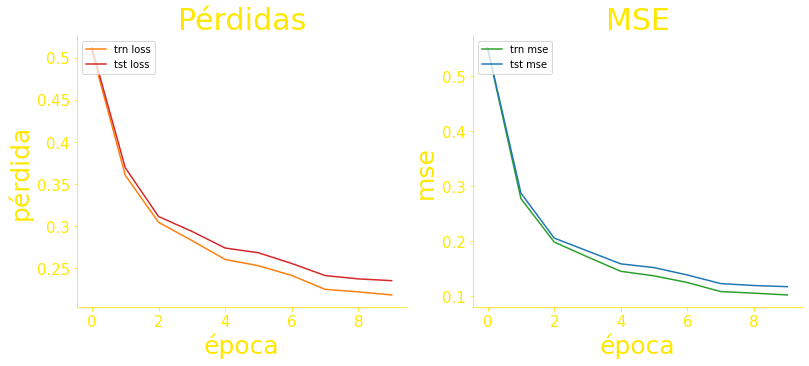

In [20]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns")

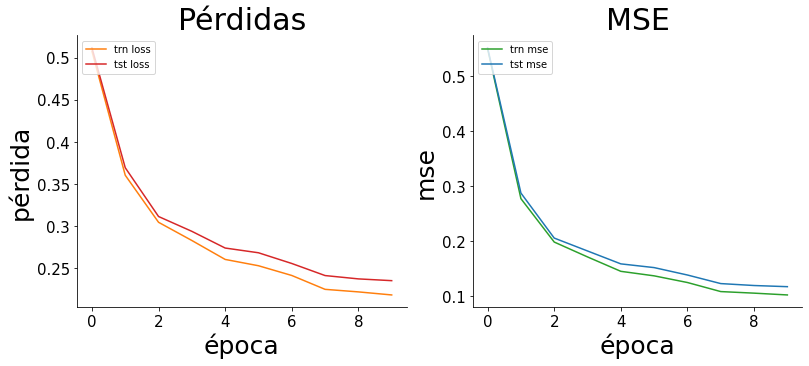

In [21]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns_black", c = "black")

[Ir a inicio](#Índice) 

## Evaluamos en entrenamiento

In [80]:
with torch.no_grad():
    preds = []
    y_trues = []
    for x, y_true in a_loader:
        out = model(x.to(device))
        y_trues.append(y_true)
        preds.append(out.squeeze().cpu())

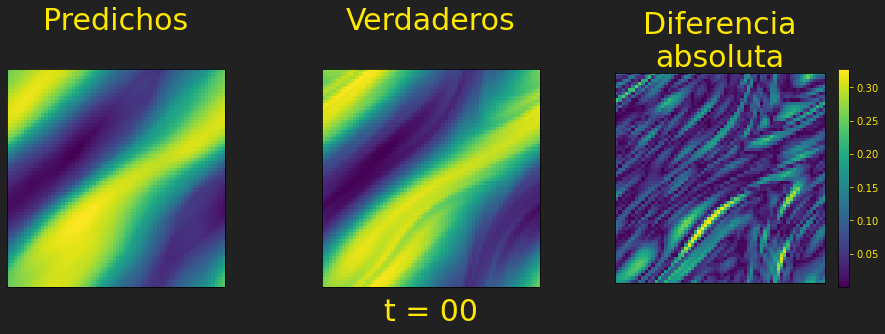

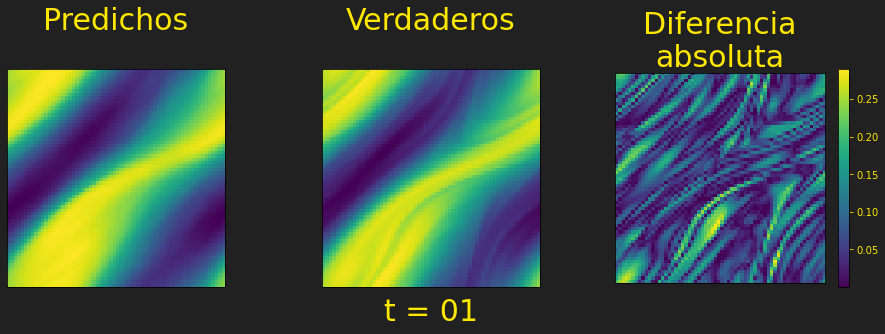

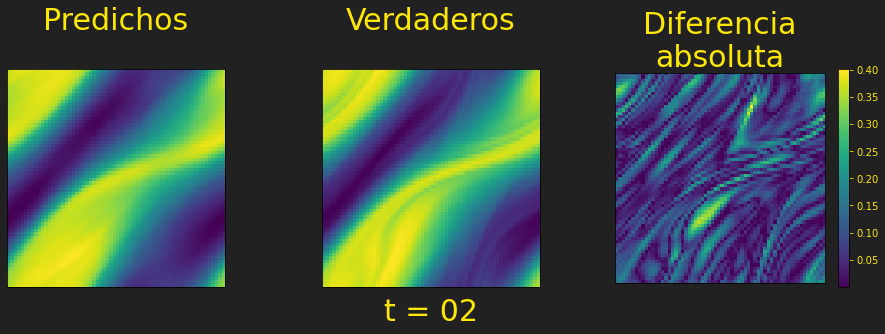

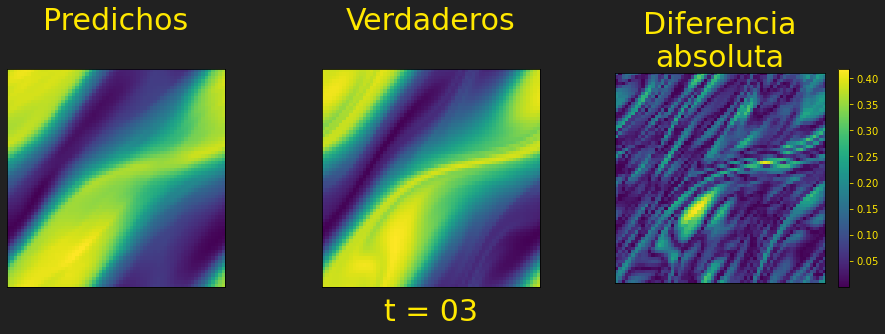

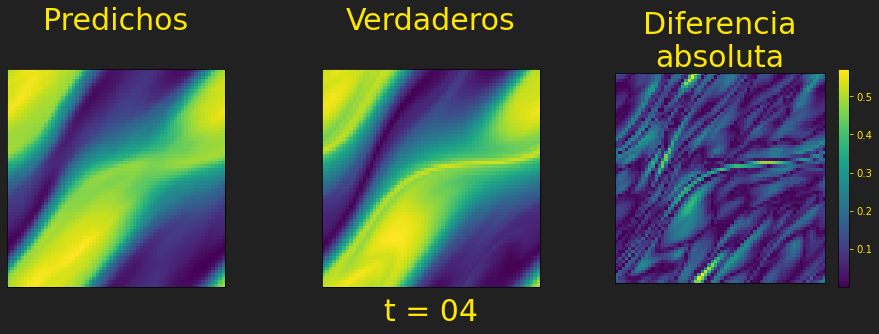

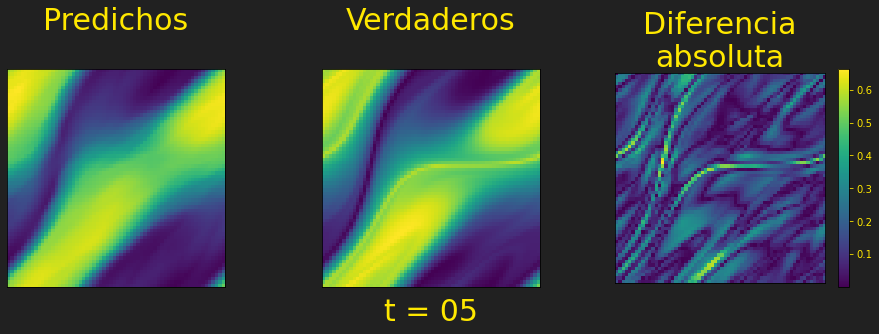

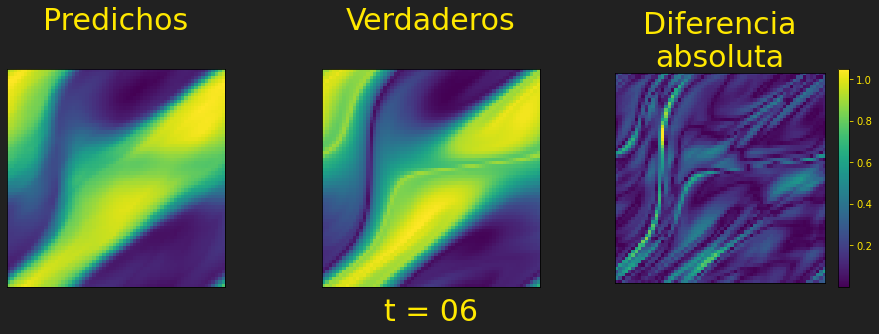

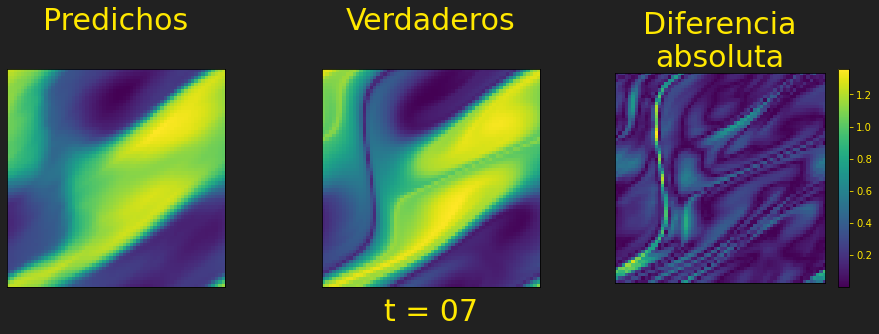

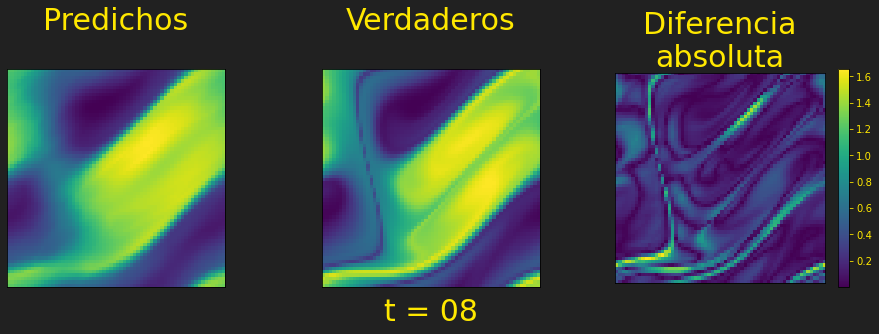

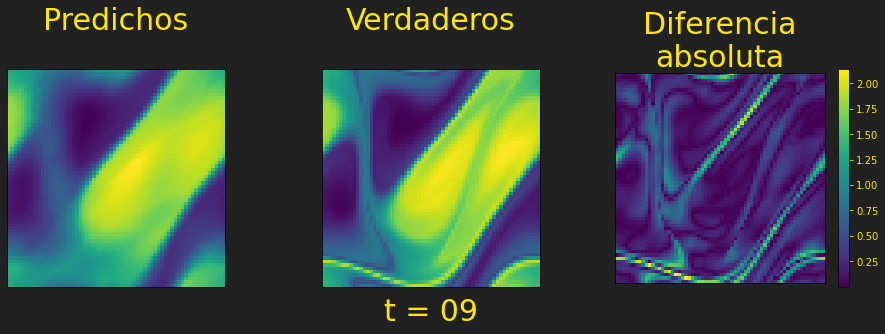

In [81]:
plot_many(preds[0][0,:,:,:], np.array(y_trues[0][0,:,:,:]), epochs)

In [82]:
create_gif(epochs)

### 300 épocas

In [ ]:
%%time
# instanciamos un modelo
model = FNO3d(modes, modes, modes, width)
# entrenamos
epochs = 300
loss_hist, mse_hist = train_GPU(model.to(device), train_loader, eval_loader, epochs=epochs)

  0%|          | 1/300 [00:13<1:04:52, 13.02s/it]

E00 
loss=[  0.57,  0.57] 
mse=[  0.69,  0.68] 



In [ ]:
#path_model = f"modelos/NS_{epochs}epochs"
#torch.save(model, path_model)

In [ ]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns")

In [ ]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns_black", c = "black")

[Ir a inicio](#Índice) 

## Evaluamos en entrenamiento

In [ ]:
with torch.no_grad():
    preds = []
    y_trues = []
    for x, y_true in test_loader:
        out = model(x.to(device))
        y_trues.append(y_true)
        preds.append(out.squeeze().cpu())

In [ ]:
plot_many(preds[0][0,:,:,:], np.array(y_trues[0][0,:,:,:]), epochs)

In [ ]:
create_gif(epochs)

### 500 épocas

In [10]:
%%time
# instanciamos un modelo
model = FNO3d(modes, modes, modes, width)
# entrenamos
epochs = 500
loss_hist, mse_hist = train_GPU(model.to(device), train_loader, eval_loader, epochs=epochs)

  0%|          | 1/500 [00:26<3:41:37, 26.65s/it]

E00 
loss=[  0.51,  0.51] 
mse=[  0.55,  0.55] 



  0%|          | 2/500 [00:39<2:32:23, 18.36s/it]

E01 
loss=[  0.35,  0.36] 
mse=[  0.26,  0.28] 



  1%|          | 3/500 [00:51<2:10:47, 15.79s/it]

E02 
loss=[  0.30,  0.31] 
mse=[  0.20,  0.21] 



  1%|          | 4/500 [01:04<2:01:17, 14.67s/it]

E03 
loss=[  0.28,  0.29] 
mse=[  0.16,  0.17] 



  1%|          | 5/500 [01:17<1:55:53, 14.05s/it]

E04 
loss=[  0.26,  0.27] 
mse=[  0.14,  0.15] 



  1%|          | 6/500 [01:30<1:53:01, 13.73s/it]

E05 
loss=[  0.25,  0.27] 
mse=[  0.13,  0.15] 



  1%|▏         | 7/500 [01:44<1:51:26, 13.56s/it]

E06 
loss=[  0.24,  0.25] 
mse=[  0.12,  0.13] 



  2%|▏         | 8/500 [01:57<1:50:30, 13.48s/it]

E07 
loss=[  0.22,  0.24] 
mse=[  0.11,  0.12] 



  2%|▏         | 9/500 [02:10<1:49:46, 13.41s/it]

E08 
loss=[  0.22,  0.23] 
mse=[  0.10,  0.12] 



  2%|▏         | 10/500 [02:24<1:49:21, 13.39s/it]

E09 
loss=[  0.21,  0.23] 
mse=[  0.10,  0.11] 



  2%|▏         | 11/500 [02:37<1:49:14, 13.40s/it]

E10 
loss=[  0.20,  0.22] 
mse=[  0.09,  0.11] 



  2%|▏         | 12/500 [02:50<1:49:12, 13.43s/it]

E11 
loss=[  0.20,  0.22] 
mse=[  0.09,  0.10] 



  3%|▎         | 13/500 [03:04<1:49:00, 13.43s/it]

E12 
loss=[  0.20,  0.22] 
mse=[  0.08,  0.10] 



  3%|▎         | 14/500 [03:17<1:49:01, 13.46s/it]

E13 
loss=[  0.20,  0.22] 
mse=[  0.08,  0.10] 



  3%|▎         | 15/500 [03:31<1:49:20, 13.53s/it]

E14 
loss=[  0.20,  0.22] 
mse=[  0.09,  0.10] 



  3%|▎         | 16/500 [03:45<1:49:43, 13.60s/it]

E15 
loss=[  0.19,  0.21] 
mse=[  0.08,  0.09] 



  3%|▎         | 17/500 [03:59<1:49:54, 13.65s/it]

E16 
loss=[  0.19,  0.21] 
mse=[  0.08,  0.09] 



  4%|▎         | 18/500 [04:13<1:50:05, 13.70s/it]

E17 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  4%|▍         | 19/500 [04:26<1:50:15, 13.75s/it]

E18 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  4%|▍         | 20/500 [04:40<1:49:52, 13.73s/it]

E19 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  4%|▍         | 21/500 [04:54<1:49:31, 13.72s/it]

E20 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  4%|▍         | 22/500 [05:08<1:49:23, 13.73s/it]

E21 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  5%|▍         | 23/500 [05:21<1:49:11, 13.73s/it]

E22 
loss=[  0.17,  0.20] 
mse=[  0.07,  0.09] 



  5%|▍         | 24/500 [05:35<1:48:50, 13.72s/it]

E23 
loss=[  0.17,  0.20] 
mse=[  0.06,  0.08] 



  5%|▌         | 25/500 [05:49<1:48:18, 13.68s/it]

E24 
loss=[  0.17,  0.20] 
mse=[  0.06,  0.08] 



  5%|▌         | 26/500 [06:02<1:48:10, 13.69s/it]

E25 
loss=[  0.17,  0.20] 
mse=[  0.06,  0.08] 



  5%|▌         | 27/500 [06:16<1:47:34, 13.65s/it]

E26 
loss=[  0.18,  0.20] 
mse=[  0.07,  0.09] 



  6%|▌         | 28/500 [06:29<1:47:19, 13.64s/it]

E27 
loss=[  0.17,  0.19] 
mse=[  0.06,  0.08] 



  6%|▌         | 29/500 [06:43<1:46:31, 13.57s/it]

E28 
loss=[  0.16,  0.19] 
mse=[  0.06,  0.08] 



  6%|▌         | 30/500 [06:56<1:46:19, 13.57s/it]

E29 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.08] 



  6%|▌         | 31/500 [07:10<1:46:17, 13.60s/it]

E30 
loss=[  0.16,  0.19] 
mse=[  0.06,  0.08] 



  6%|▋         | 32/500 [07:24<1:45:59, 13.59s/it]

E31 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.08] 



  7%|▋         | 33/500 [07:37<1:45:52, 13.60s/it]

E32 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.07] 



  7%|▋         | 34/500 [07:51<1:45:21, 13.56s/it]

E33 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.08] 



  7%|▋         | 35/500 [08:04<1:44:34, 13.49s/it]

E34 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.08] 



  7%|▋         | 36/500 [08:18<1:44:19, 13.49s/it]

E35 
loss=[  0.16,  0.19] 
mse=[  0.06,  0.08] 



  7%|▋         | 37/500 [08:31<1:44:14, 13.51s/it]

E36 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.07] 



  8%|▊         | 38/500 [08:44<1:43:41, 13.47s/it]

E37 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



  8%|▊         | 39/500 [08:58<1:43:36, 13.49s/it]

E38 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



  8%|▊         | 40/500 [09:11<1:43:12, 13.46s/it]

E39 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



  8%|▊         | 41/500 [09:25<1:42:50, 13.44s/it]

E40 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



  8%|▊         | 42/500 [09:38<1:42:27, 13.42s/it]

E41 
loss=[  0.16,  0.19] 
mse=[  0.05,  0.08] 



  9%|▊         | 43/500 [09:52<1:42:10, 13.41s/it]

E42 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



  9%|▉         | 44/500 [10:05<1:42:05, 13.43s/it]

E43 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



  9%|▉         | 45/500 [10:18<1:41:51, 13.43s/it]

E44 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



  9%|▉         | 46/500 [10:32<1:41:30, 13.42s/it]

E45 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



  9%|▉         | 47/500 [10:46<1:42:18, 13.55s/it]

E46 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



 10%|▉         | 48/500 [10:59<1:41:38, 13.49s/it]

E47 
loss=[  0.16,  0.19] 
mse=[  0.06,  0.08] 



 10%|▉         | 49/500 [11:12<1:41:09, 13.46s/it]

E48 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



 10%|█         | 50/500 [11:26<1:41:24, 13.52s/it]

E49 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



 10%|█         | 51/500 [11:40<1:41:49, 13.61s/it]

E50 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



 10%|█         | 52/500 [11:53<1:40:40, 13.48s/it]

E51 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



 11%|█         | 53/500 [12:06<1:39:50, 13.40s/it]

E52 
loss=[  0.15,  0.19] 
mse=[  0.05,  0.07] 



 11%|█         | 54/500 [12:20<1:39:16, 13.36s/it]

E53 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



 11%|█         | 55/500 [12:33<1:38:40, 13.31s/it]

E54 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 11%|█         | 56/500 [12:46<1:38:12, 13.27s/it]

E55 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 11%|█▏        | 57/500 [12:59<1:37:50, 13.25s/it]

E56 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 12%|█▏        | 58/500 [13:14<1:41:08, 13.73s/it]

E57 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 12%|█▏        | 59/500 [13:27<1:39:38, 13.56s/it]

E58 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 12%|█▏        | 60/500 [13:40<1:38:35, 13.44s/it]

E59 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 12%|█▏        | 61/500 [13:54<1:37:47, 13.36s/it]

E60 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 12%|█▏        | 62/500 [14:07<1:37:09, 13.31s/it]

E61 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 13%|█▎        | 63/500 [14:20<1:36:40, 13.27s/it]

E62 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 13%|█▎        | 64/500 [14:33<1:36:15, 13.25s/it]

E63 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 13%|█▎        | 65/500 [14:46<1:36:08, 13.26s/it]

E64 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 13%|█▎        | 66/500 [15:00<1:35:44, 13.24s/it]

E65 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 13%|█▎        | 67/500 [15:13<1:35:24, 13.22s/it]

E66 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 14%|█▎        | 68/500 [15:26<1:35:06, 13.21s/it]

E67 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 14%|█▍        | 69/500 [15:39<1:34:49, 13.20s/it]

E68 
loss=[  0.15,  0.18] 
mse=[  0.05,  0.07] 



 14%|█▍        | 70/500 [15:52<1:34:34, 13.20s/it]

E69 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 14%|█▍        | 71/500 [16:05<1:34:19, 13.19s/it]

E70 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 14%|█▍        | 72/500 [16:19<1:34:05, 13.19s/it]

E71 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 15%|█▍        | 73/500 [16:32<1:33:49, 13.18s/it]

E72 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 15%|█▍        | 74/500 [16:45<1:33:35, 13.18s/it]

E73 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 15%|█▌        | 75/500 [16:58<1:33:22, 13.18s/it]

E74 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 15%|█▌        | 76/500 [17:11<1:33:09, 13.18s/it]

E75 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 15%|█▌        | 77/500 [17:25<1:32:56, 13.18s/it]

E76 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 16%|█▌        | 78/500 [17:38<1:32:42, 13.18s/it]

E77 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 16%|█▌        | 79/500 [17:51<1:32:30, 13.18s/it]

E78 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 16%|█▌        | 80/500 [18:04<1:32:19, 13.19s/it]

E79 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 16%|█▌        | 81/500 [18:17<1:32:05, 13.19s/it]

E80 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 16%|█▋        | 82/500 [18:31<1:31:56, 13.20s/it]

E81 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 17%|█▋        | 83/500 [18:44<1:31:42, 13.20s/it]

E82 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 17%|█▋        | 84/500 [18:57<1:31:29, 13.20s/it]

E83 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 17%|█▋        | 85/500 [19:10<1:31:15, 13.19s/it]

E84 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 17%|█▋        | 86/500 [19:23<1:31:02, 13.19s/it]

E85 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 17%|█▋        | 87/500 [19:36<1:30:47, 13.19s/it]

E86 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 18%|█▊        | 88/500 [19:50<1:30:33, 13.19s/it]

E87 
loss=[  0.13,  0.17] 
mse=[  0.04,  0.07] 



 18%|█▊        | 89/500 [20:03<1:30:20, 13.19s/it]

E88 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 18%|█▊        | 90/500 [20:16<1:30:07, 13.19s/it]

E89 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 18%|█▊        | 91/500 [20:29<1:29:52, 13.18s/it]

E90 
loss=[  0.13,  0.17] 
mse=[  0.04,  0.07] 



 18%|█▊        | 92/500 [20:42<1:29:38, 13.18s/it]

E91 
loss=[  0.13,  0.17] 
mse=[  0.04,  0.06] 



 19%|█▊        | 93/500 [20:56<1:29:28, 13.19s/it]

E92 
loss=[  0.13,  0.17] 
mse=[  0.04,  0.06] 



 19%|█▉        | 94/500 [21:09<1:29:15, 13.19s/it]

E93 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 19%|█▉        | 95/500 [21:22<1:29:01, 13.19s/it]

E94 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 19%|█▉        | 96/500 [21:35<1:28:50, 13.19s/it]

E95 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 19%|█▉        | 97/500 [21:48<1:28:35, 13.19s/it]

E96 
loss=[  0.14,  0.18] 
mse=[  0.04,  0.07] 



 20%|█▉        | 98/500 [22:02<1:28:23, 13.19s/it]

E97 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 20%|█▉        | 99/500 [22:15<1:28:08, 13.19s/it]

E98 
loss=[  0.13,  0.18] 
mse=[  0.04,  0.07] 



 20%|██        | 100/500 [22:28<1:27:56, 13.19s/it]

E99 
loss=[  0.13,  0.17] 
mse=[  0.04,  0.06] 



 20%|██        | 101/500 [22:41<1:27:42, 13.19s/it]

E100 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 20%|██        | 102/500 [22:54<1:27:30, 13.19s/it]

E101 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 21%|██        | 103/500 [23:08<1:27:17, 13.19s/it]

E102 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 21%|██        | 104/500 [23:21<1:27:05, 13.20s/it]

E103 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 21%|██        | 105/500 [23:34<1:26:53, 13.20s/it]

E104 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 21%|██        | 106/500 [23:47<1:26:38, 13.19s/it]

E105 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 21%|██▏       | 107/500 [24:00<1:26:26, 13.20s/it]

E106 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 22%|██▏       | 108/500 [24:14<1:26:12, 13.19s/it]

E107 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 22%|██▏       | 109/500 [24:27<1:25:58, 13.19s/it]

E108 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 22%|██▏       | 110/500 [24:40<1:25:44, 13.19s/it]

E109 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 22%|██▏       | 111/500 [24:53<1:25:32, 13.19s/it]

E110 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 22%|██▏       | 112/500 [25:06<1:25:21, 13.20s/it]

E111 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 23%|██▎       | 113/500 [25:19<1:25:07, 13.20s/it]

E112 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 23%|██▎       | 114/500 [25:33<1:24:53, 13.20s/it]

E113 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 23%|██▎       | 115/500 [25:46<1:24:41, 13.20s/it]

E114 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 23%|██▎       | 116/500 [25:59<1:24:27, 13.20s/it]

E115 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 23%|██▎       | 117/500 [26:12<1:24:12, 13.19s/it]

E116 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 24%|██▎       | 118/500 [26:26<1:24:08, 13.22s/it]

E117 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 24%|██▍       | 119/500 [26:39<1:23:53, 13.21s/it]

E118 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 24%|██▍       | 120/500 [26:52<1:23:39, 13.21s/it]

E119 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 24%|██▍       | 121/500 [27:05<1:23:25, 13.21s/it]

E120 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 24%|██▍       | 122/500 [27:18<1:23:11, 13.21s/it]

E121 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 25%|██▍       | 123/500 [27:32<1:22:58, 13.20s/it]

E122 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 25%|██▍       | 124/500 [27:45<1:22:45, 13.21s/it]

E123 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 25%|██▌       | 125/500 [27:58<1:22:31, 13.20s/it]

E124 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 25%|██▌       | 126/500 [28:11<1:22:18, 13.21s/it]

E125 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 25%|██▌       | 127/500 [28:24<1:22:04, 13.20s/it]

E126 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 26%|██▌       | 128/500 [28:38<1:21:50, 13.20s/it]

E127 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 26%|██▌       | 129/500 [28:51<1:21:37, 13.20s/it]

E128 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 26%|██▌       | 130/500 [29:04<1:22:02, 13.30s/it]

E129 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 26%|██▌       | 131/500 [29:18<1:21:39, 13.28s/it]

E130 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 26%|██▋       | 132/500 [29:31<1:21:23, 13.27s/it]

E131 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 27%|██▋       | 133/500 [29:44<1:21:07, 13.26s/it]

E132 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 27%|██▋       | 134/500 [29:57<1:20:54, 13.26s/it]

E133 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 27%|██▋       | 135/500 [30:11<1:20:39, 13.26s/it]

E134 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 27%|██▋       | 136/500 [30:24<1:20:25, 13.26s/it]

E135 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 27%|██▋       | 137/500 [30:37<1:20:13, 13.26s/it]

E136 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 28%|██▊       | 138/500 [30:50<1:20:00, 13.26s/it]

E137 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 28%|██▊       | 139/500 [31:04<1:19:48, 13.26s/it]

E138 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 28%|██▊       | 140/500 [31:17<1:19:36, 13.27s/it]

E139 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 28%|██▊       | 141/500 [31:30<1:19:25, 13.27s/it]

E140 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 28%|██▊       | 142/500 [31:43<1:19:13, 13.28s/it]

E141 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 29%|██▊       | 143/500 [31:57<1:19:00, 13.28s/it]

E142 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 29%|██▉       | 144/500 [32:10<1:18:51, 13.29s/it]

E143 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 29%|██▉       | 145/500 [32:23<1:18:44, 13.31s/it]

E144 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 29%|██▉       | 146/500 [32:37<1:18:34, 13.32s/it]

E145 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 29%|██▉       | 147/500 [32:50<1:18:25, 13.33s/it]

E146 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 30%|██▉       | 148/500 [33:03<1:18:18, 13.35s/it]

E147 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 30%|██▉       | 149/500 [33:17<1:18:07, 13.35s/it]

E148 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 30%|███       | 150/500 [33:30<1:17:56, 13.36s/it]

E149 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 30%|███       | 151/500 [33:44<1:17:46, 13.37s/it]

E150 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 30%|███       | 152/500 [33:57<1:17:41, 13.40s/it]

E151 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 31%|███       | 153/500 [34:10<1:17:32, 13.41s/it]

E152 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 31%|███       | 154/500 [34:24<1:17:28, 13.43s/it]

E153 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 31%|███       | 155/500 [34:38<1:17:22, 13.46s/it]

E154 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.07] 



 31%|███       | 156/500 [34:51<1:17:16, 13.48s/it]

E155 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 31%|███▏      | 157/500 [35:05<1:17:11, 13.50s/it]

E156 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 32%|███▏      | 158/500 [35:18<1:17:03, 13.52s/it]

E157 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 32%|███▏      | 159/500 [35:32<1:16:57, 13.54s/it]

E158 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 32%|███▏      | 160/500 [35:45<1:16:51, 13.56s/it]

E159 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 32%|███▏      | 161/500 [35:59<1:16:43, 13.58s/it]

E160 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 32%|███▏      | 162/500 [36:13<1:16:31, 13.58s/it]

E161 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 33%|███▎      | 163/500 [36:26<1:16:17, 13.58s/it]

E162 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 33%|███▎      | 164/500 [36:40<1:16:06, 13.59s/it]

E163 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 33%|███▎      | 165/500 [36:54<1:16:12, 13.65s/it]

E164 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 33%|███▎      | 166/500 [37:07<1:16:02, 13.66s/it]

E165 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 33%|███▎      | 167/500 [37:21<1:16:06, 13.71s/it]

E166 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 34%|███▎      | 168/500 [37:35<1:15:59, 13.73s/it]

E167 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 34%|███▍      | 169/500 [37:48<1:15:31, 13.69s/it]

E168 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 34%|███▍      | 170/500 [38:02<1:15:17, 13.69s/it]

E169 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 34%|███▍      | 171/500 [38:16<1:15:01, 13.68s/it]

E170 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 34%|███▍      | 172/500 [38:30<1:14:58, 13.71s/it]

E171 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 35%|███▍      | 173/500 [38:43<1:14:50, 13.73s/it]

E172 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 35%|███▍      | 174/500 [38:57<1:14:21, 13.69s/it]

E173 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 35%|███▌      | 175/500 [39:10<1:13:55, 13.65s/it]

E174 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 35%|███▌      | 176/500 [39:24<1:13:27, 13.60s/it]

E175 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 35%|███▌      | 177/500 [39:38<1:13:09, 13.59s/it]

E176 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 36%|███▌      | 178/500 [39:51<1:12:46, 13.56s/it]

E177 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 36%|███▌      | 179/500 [40:05<1:12:33, 13.56s/it]

E178 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 36%|███▌      | 180/500 [40:18<1:12:14, 13.55s/it]

E179 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 36%|███▌      | 181/500 [40:32<1:12:25, 13.62s/it]

E180 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 36%|███▋      | 182/500 [40:45<1:12:04, 13.60s/it]

E181 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 37%|███▋      | 183/500 [40:59<1:11:44, 13.58s/it]

E182 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 37%|███▋      | 184/500 [41:12<1:11:23, 13.55s/it]

E183 
loss=[  0.12,  0.17] 
mse=[  0.03,  0.06] 



 37%|███▋      | 185/500 [41:26<1:11:21, 13.59s/it]

E184 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 37%|███▋      | 186/500 [41:40<1:11:05, 13.58s/it]

E185 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 37%|███▋      | 187/500 [41:53<1:10:47, 13.57s/it]

E186 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 38%|███▊      | 188/500 [42:07<1:10:31, 13.56s/it]

E187 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 38%|███▊      | 189/500 [42:20<1:10:15, 13.55s/it]

E188 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 38%|███▊      | 190/500 [42:34<1:09:51, 13.52s/it]

E189 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 38%|███▊      | 191/500 [42:47<1:09:46, 13.55s/it]

E190 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 38%|███▊      | 192/500 [43:01<1:09:52, 13.61s/it]

E191 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 39%|███▊      | 193/500 [43:14<1:09:08, 13.51s/it]

E192 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 39%|███▉      | 194/500 [43:28<1:08:34, 13.44s/it]

E193 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 39%|███▉      | 195/500 [43:41<1:08:02, 13.39s/it]

E194 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 39%|███▉      | 196/500 [43:54<1:07:35, 13.34s/it]

E195 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 39%|███▉      | 197/500 [44:07<1:07:12, 13.31s/it]

E196 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 40%|███▉      | 198/500 [44:21<1:06:52, 13.29s/it]

E197 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 40%|███▉      | 199/500 [44:34<1:06:34, 13.27s/it]

E198 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 40%|████      | 200/500 [44:49<1:08:43, 13.75s/it]

E199 
loss=[  0.11,  0.17] 
mse=[  0.03,  0.06] 



 40%|████      | 201/500 [45:02<1:07:40, 13.58s/it]

E200 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 40%|████      | 202/500 [45:15<1:06:53, 13.47s/it]

E201 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 41%|████      | 203/500 [45:29<1:06:44, 13.48s/it]

E202 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 41%|████      | 204/500 [45:42<1:06:07, 13.40s/it]

E203 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 41%|████      | 205/500 [45:55<1:05:40, 13.36s/it]

E204 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 41%|████      | 206/500 [46:08<1:05:16, 13.32s/it]

E205 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 41%|████▏     | 207/500 [46:22<1:04:55, 13.29s/it]

E206 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 42%|████▏     | 208/500 [46:35<1:04:36, 13.27s/it]

E207 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 42%|████▏     | 209/500 [46:48<1:04:21, 13.27s/it]

E208 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 42%|████▏     | 210/500 [47:01<1:04:03, 13.26s/it]

E209 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 42%|████▏     | 211/500 [47:15<1:03:48, 13.25s/it]

E210 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 42%|████▏     | 212/500 [47:28<1:03:41, 13.27s/it]

E211 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 43%|████▎     | 213/500 [47:41<1:03:26, 13.26s/it]

E212 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 43%|████▎     | 214/500 [47:54<1:03:11, 13.26s/it]

E213 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 43%|████▎     | 215/500 [48:08<1:02:57, 13.25s/it]

E214 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 43%|████▎     | 216/500 [48:21<1:02:45, 13.26s/it]

E215 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 43%|████▎     | 217/500 [48:34<1:02:31, 13.25s/it]

E216 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 44%|████▎     | 218/500 [48:47<1:02:17, 13.25s/it]

E217 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 44%|████▍     | 219/500 [49:01<1:02:03, 13.25s/it]

E218 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 44%|████▍     | 220/500 [49:14<1:01:50, 13.25s/it]

E219 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 44%|████▍     | 221/500 [49:27<1:01:37, 13.25s/it]

E220 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 44%|████▍     | 222/500 [49:40<1:01:24, 13.26s/it]

E221 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 45%|████▍     | 223/500 [49:54<1:01:10, 13.25s/it]

E222 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 45%|████▍     | 224/500 [50:07<1:00:54, 13.24s/it]

E223 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 45%|████▌     | 225/500 [50:20<1:00:40, 13.24s/it]

E224 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 45%|████▌     | 226/500 [50:33<1:00:25, 13.23s/it]

E225 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 45%|████▌     | 227/500 [50:47<1:00:27, 13.29s/it]

E226 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 46%|████▌     | 228/500 [51:00<1:00:08, 13.27s/it]

E227 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 46%|████▌     | 229/500 [51:13<59:51, 13.25s/it]  

E228 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 46%|████▌     | 230/500 [51:26<59:35, 13.24s/it]

E229 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 46%|████▌     | 231/500 [51:40<59:20, 13.24s/it]

E230 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 46%|████▋     | 232/500 [51:53<59:07, 13.24s/it]

E231 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 47%|████▋     | 233/500 [52:06<58:54, 13.24s/it]

E232 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 47%|████▋     | 234/500 [52:19<58:40, 13.23s/it]

E233 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 47%|████▋     | 235/500 [52:33<58:27, 13.23s/it]

E234 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 47%|████▋     | 236/500 [52:46<58:12, 13.23s/it]

E235 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 47%|████▋     | 237/500 [52:59<57:59, 13.23s/it]

E236 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 48%|████▊     | 238/500 [53:12<57:46, 13.23s/it]

E237 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 48%|████▊     | 239/500 [53:25<57:32, 13.23s/it]

E238 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 48%|████▊     | 240/500 [53:39<57:18, 13.23s/it]

E239 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 48%|████▊     | 241/500 [53:52<57:05, 13.23s/it]

E240 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 48%|████▊     | 242/500 [54:05<56:55, 13.24s/it]

E241 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 49%|████▊     | 243/500 [54:18<56:40, 13.23s/it]

E242 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 49%|████▉     | 244/500 [54:32<56:27, 13.23s/it]

E243 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 49%|████▉     | 245/500 [54:45<56:14, 13.23s/it]

E244 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 49%|████▉     | 246/500 [54:58<55:59, 13.23s/it]

E245 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 49%|████▉     | 247/500 [55:11<55:46, 13.23s/it]

E246 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 50%|████▉     | 248/500 [55:25<55:33, 13.23s/it]

E247 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 50%|████▉     | 249/500 [55:38<55:20, 13.23s/it]

E248 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 50%|█████     | 250/500 [55:51<55:15, 13.26s/it]

E249 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 50%|█████     | 251/500 [56:04<54:59, 13.25s/it]

E250 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 50%|█████     | 252/500 [56:18<54:43, 13.24s/it]

E251 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 51%|█████     | 253/500 [56:31<54:30, 13.24s/it]

E252 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 51%|█████     | 254/500 [56:44<54:26, 13.28s/it]

E253 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 51%|█████     | 255/500 [56:57<54:08, 13.26s/it]

E254 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 51%|█████     | 256/500 [57:11<53:54, 13.25s/it]

E255 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 51%|█████▏    | 257/500 [57:24<53:38, 13.25s/it]

E256 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 52%|█████▏    | 258/500 [57:37<53:26, 13.25s/it]

E257 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 52%|█████▏    | 259/500 [57:50<53:12, 13.25s/it]

E258 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 52%|█████▏    | 260/500 [58:04<52:58, 13.24s/it]

E259 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 52%|█████▏    | 261/500 [58:17<52:47, 13.25s/it]

E260 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 52%|█████▏    | 262/500 [58:30<52:34, 13.25s/it]

E261 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 53%|█████▎    | 263/500 [58:43<52:18, 13.24s/it]

E262 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 53%|█████▎    | 264/500 [58:57<52:02, 13.23s/it]

E263 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 53%|█████▎    | 265/500 [59:10<51:48, 13.23s/it]

E264 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 53%|█████▎    | 266/500 [59:23<51:34, 13.22s/it]

E265 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 53%|█████▎    | 267/500 [59:36<51:20, 13.22s/it]

E266 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 54%|█████▎    | 268/500 [59:49<51:08, 13.23s/it]

E267 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 54%|█████▍    | 269/500 [1:00:03<50:56, 13.23s/it]

E268 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 54%|█████▍    | 270/500 [1:00:16<50:43, 13.23s/it]

E269 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 54%|█████▍    | 271/500 [1:00:29<50:29, 13.23s/it]

E270 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 54%|█████▍    | 272/500 [1:00:42<50:16, 13.23s/it]

E271 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 55%|█████▍    | 273/500 [1:00:56<50:03, 13.23s/it]

E272 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 55%|█████▍    | 274/500 [1:01:09<49:50, 13.23s/it]

E273 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 55%|█████▌    | 275/500 [1:01:22<49:37, 13.23s/it]

E274 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 55%|█████▌    | 276/500 [1:01:35<49:24, 13.23s/it]

E275 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 55%|█████▌    | 277/500 [1:01:49<49:11, 13.23s/it]

E276 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 56%|█████▌    | 278/500 [1:02:02<48:57, 13.23s/it]

E277 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 56%|█████▌    | 279/500 [1:02:15<48:44, 13.23s/it]

E278 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 56%|█████▌    | 280/500 [1:02:28<48:31, 13.23s/it]

E279 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 56%|█████▌    | 281/500 [1:02:41<48:17, 13.23s/it]

E280 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 56%|█████▋    | 282/500 [1:02:55<48:03, 13.23s/it]

E281 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 57%|█████▋    | 283/500 [1:03:08<47:50, 13.23s/it]

E282 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 57%|█████▋    | 284/500 [1:03:21<47:37, 13.23s/it]

E283 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 57%|█████▋    | 285/500 [1:03:34<47:24, 13.23s/it]

E284 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 57%|█████▋    | 286/500 [1:03:48<47:11, 13.23s/it]

E285 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 57%|█████▋    | 287/500 [1:04:01<46:59, 13.24s/it]

E286 
loss=[  0.11,  0.17] 
mse=[  0.02,  0.06] 



 58%|█████▊    | 288/500 [1:04:14<47:03, 13.32s/it]

E287 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 58%|█████▊    | 289/500 [1:04:28<46:49, 13.32s/it]

E288 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 58%|█████▊    | 290/500 [1:04:41<46:33, 13.30s/it]

E289 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 58%|█████▊    | 291/500 [1:04:54<46:16, 13.29s/it]

E290 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 58%|█████▊    | 292/500 [1:05:07<46:03, 13.29s/it]

E291 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 59%|█████▊    | 293/500 [1:05:21<45:50, 13.29s/it]

E292 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 59%|█████▉    | 294/500 [1:05:34<45:36, 13.28s/it]

E293 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 59%|█████▉    | 295/500 [1:05:47<45:25, 13.30s/it]

E294 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 59%|█████▉    | 296/500 [1:06:01<45:14, 13.31s/it]

E295 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 59%|█████▉    | 297/500 [1:06:14<45:00, 13.30s/it]

E296 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 60%|█████▉    | 298/500 [1:06:27<44:46, 13.30s/it]

E297 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 60%|█████▉    | 299/500 [1:06:41<44:33, 13.30s/it]

E298 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 60%|██████    | 300/500 [1:06:54<44:20, 13.30s/it]

E299 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 60%|██████    | 301/500 [1:07:07<44:08, 13.31s/it]

E300 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 60%|██████    | 302/500 [1:07:21<43:57, 13.32s/it]

E301 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 61%|██████    | 303/500 [1:07:34<43:44, 13.32s/it]

E302 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 61%|██████    | 304/500 [1:07:47<43:32, 13.33s/it]

E303 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 61%|██████    | 305/500 [1:08:01<43:20, 13.34s/it]

E304 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 61%|██████    | 306/500 [1:08:14<43:09, 13.35s/it]

E305 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 61%|██████▏   | 307/500 [1:08:27<42:59, 13.37s/it]

E306 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 62%|██████▏   | 308/500 [1:08:41<42:47, 13.37s/it]

E307 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 62%|██████▏   | 309/500 [1:08:54<42:36, 13.39s/it]

E308 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 62%|██████▏   | 310/500 [1:09:08<42:24, 13.39s/it]

E309 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 62%|██████▏   | 311/500 [1:09:21<42:13, 13.41s/it]

E310 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 62%|██████▏   | 312/500 [1:09:34<42:04, 13.43s/it]

E311 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 63%|██████▎   | 313/500 [1:09:48<41:54, 13.45s/it]

E312 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 63%|██████▎   | 314/500 [1:10:01<41:43, 13.46s/it]

E313 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 63%|██████▎   | 315/500 [1:10:15<41:32, 13.47s/it]

E314 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 63%|██████▎   | 316/500 [1:10:29<41:33, 13.55s/it]

E315 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 63%|██████▎   | 317/500 [1:10:42<41:31, 13.61s/it]

E316 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 64%|██████▎   | 318/500 [1:10:56<41:14, 13.59s/it]

E317 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 64%|██████▍   | 319/500 [1:11:10<40:58, 13.58s/it]

E318 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 64%|██████▍   | 320/500 [1:11:23<40:48, 13.60s/it]

E319 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 64%|██████▍   | 321/500 [1:11:37<40:40, 13.63s/it]

E320 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 64%|██████▍   | 322/500 [1:11:50<40:23, 13.61s/it]

E321 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 65%|██████▍   | 323/500 [1:12:04<40:10, 13.62s/it]

E322 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 65%|██████▍   | 324/500 [1:12:18<39:55, 13.61s/it]

E323 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 65%|██████▌   | 325/500 [1:12:31<39:31, 13.55s/it]

E324 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 65%|██████▌   | 326/500 [1:12:45<39:23, 13.58s/it]

E325 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 65%|██████▌   | 327/500 [1:12:58<39:06, 13.56s/it]

E326 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 66%|██████▌   | 328/500 [1:13:12<38:59, 13.60s/it]

E327 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 66%|██████▌   | 329/500 [1:13:26<38:47, 13.61s/it]

E328 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 66%|██████▌   | 330/500 [1:13:39<38:41, 13.65s/it]

E329 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 66%|██████▌   | 331/500 [1:13:53<38:32, 13.68s/it]

E330 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 66%|██████▋   | 332/500 [1:14:07<38:18, 13.68s/it]

E331 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 67%|██████▋   | 333/500 [1:14:20<38:03, 13.67s/it]

E332 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 67%|██████▋   | 334/500 [1:14:34<37:52, 13.69s/it]

E333 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 67%|██████▋   | 335/500 [1:14:48<37:30, 13.64s/it]

E334 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 67%|██████▋   | 336/500 [1:15:01<37:15, 13.63s/it]

E335 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 67%|██████▋   | 337/500 [1:15:15<36:55, 13.59s/it]

E336 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 68%|██████▊   | 338/500 [1:15:30<37:58, 14.07s/it]

E337 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 68%|██████▊   | 339/500 [1:15:44<37:17, 13.90s/it]

E338 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 68%|██████▊   | 340/500 [1:15:57<36:48, 13.81s/it]

E339 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 68%|██████▊   | 341/500 [1:16:11<36:23, 13.73s/it]

E340 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 68%|██████▊   | 342/500 [1:16:24<35:56, 13.65s/it]

E341 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 69%|██████▊   | 343/500 [1:16:38<35:36, 13.61s/it]

E342 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 69%|██████▉   | 344/500 [1:16:51<35:16, 13.57s/it]

E343 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 69%|██████▉   | 345/500 [1:17:05<34:57, 13.53s/it]

E344 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 69%|██████▉   | 346/500 [1:17:18<34:46, 13.55s/it]

E345 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 69%|██████▉   | 347/500 [1:17:32<34:36, 13.57s/it]

E346 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 70%|██████▉   | 348/500 [1:17:45<34:20, 13.55s/it]

E347 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 70%|██████▉   | 349/500 [1:17:59<34:05, 13.55s/it]

E348 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 70%|███████   | 350/500 [1:18:12<33:51, 13.55s/it]

E349 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 70%|███████   | 351/500 [1:18:26<33:37, 13.54s/it]

E350 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 70%|███████   | 352/500 [1:18:40<33:38, 13.64s/it]

E351 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 71%|███████   | 353/500 [1:18:54<33:49, 13.81s/it]

E352 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 71%|███████   | 354/500 [1:19:07<33:11, 13.64s/it]

E353 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 71%|███████   | 355/500 [1:19:20<32:42, 13.53s/it]

E354 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 71%|███████   | 356/500 [1:19:34<32:21, 13.48s/it]

E355 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 71%|███████▏  | 357/500 [1:19:47<31:58, 13.42s/it]

E356 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 72%|███████▏  | 358/500 [1:20:00<31:38, 13.37s/it]

E357 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 72%|███████▏  | 359/500 [1:20:15<32:29, 13.82s/it]

E358 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 72%|███████▏  | 360/500 [1:20:28<31:49, 13.64s/it]

E359 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 72%|███████▏  | 361/500 [1:20:42<31:21, 13.53s/it]

E360 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 72%|███████▏  | 362/500 [1:20:55<30:55, 13.45s/it]

E361 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 73%|███████▎  | 363/500 [1:21:08<30:37, 13.41s/it]

E362 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 73%|███████▎  | 364/500 [1:21:22<30:17, 13.36s/it]

E363 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 73%|███████▎  | 365/500 [1:21:35<30:21, 13.49s/it]

E364 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 73%|███████▎  | 366/500 [1:21:49<29:56, 13.41s/it]

E365 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 73%|███████▎  | 367/500 [1:22:02<29:36, 13.36s/it]

E366 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 74%|███████▎  | 368/500 [1:22:15<29:19, 13.33s/it]

E367 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 74%|███████▍  | 369/500 [1:22:28<29:03, 13.31s/it]

E368 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 74%|███████▍  | 370/500 [1:22:42<28:47, 13.29s/it]

E369 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 74%|███████▍  | 371/500 [1:22:55<28:32, 13.27s/it]

E370 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 74%|███████▍  | 372/500 [1:23:08<28:18, 13.27s/it]

E371 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 75%|███████▍  | 373/500 [1:23:21<28:03, 13.26s/it]

E372 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 75%|███████▍  | 374/500 [1:23:35<27:49, 13.25s/it]

E373 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 75%|███████▌  | 375/500 [1:23:48<27:35, 13.25s/it]

E374 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 75%|███████▌  | 376/500 [1:24:01<27:22, 13.25s/it]

E375 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 75%|███████▌  | 377/500 [1:24:14<27:08, 13.24s/it]

E376 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 76%|███████▌  | 378/500 [1:24:27<26:54, 13.24s/it]

E377 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 76%|███████▌  | 379/500 [1:24:41<26:41, 13.24s/it]

E378 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 76%|███████▌  | 380/500 [1:24:54<26:28, 13.24s/it]

E379 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 76%|███████▌  | 381/500 [1:25:07<26:15, 13.24s/it]

E380 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 76%|███████▋  | 382/500 [1:25:20<26:01, 13.23s/it]

E381 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 77%|███████▋  | 383/500 [1:25:34<25:48, 13.23s/it]

E382 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 77%|███████▋  | 384/500 [1:25:47<25:34, 13.23s/it]

E383 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 77%|███████▋  | 385/500 [1:26:00<25:21, 13.23s/it]

E384 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 77%|███████▋  | 386/500 [1:26:13<25:08, 13.23s/it]

E385 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 77%|███████▋  | 387/500 [1:26:27<24:56, 13.24s/it]

E386 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 78%|███████▊  | 388/500 [1:26:40<24:42, 13.24s/it]

E387 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 78%|███████▊  | 389/500 [1:26:53<24:28, 13.23s/it]

E388 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 78%|███████▊  | 390/500 [1:27:06<24:15, 13.23s/it]

E389 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 78%|███████▊  | 391/500 [1:27:19<24:01, 13.22s/it]

E390 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 78%|███████▊  | 392/500 [1:27:33<23:49, 13.24s/it]

E391 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 79%|███████▊  | 393/500 [1:27:46<23:35, 13.23s/it]

E392 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 79%|███████▉  | 394/500 [1:27:59<23:22, 13.23s/it]

E393 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 79%|███████▉  | 395/500 [1:28:12<23:08, 13.23s/it]

E394 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 79%|███████▉  | 396/500 [1:28:26<22:55, 13.22s/it]

E395 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 79%|███████▉  | 397/500 [1:28:39<22:42, 13.23s/it]

E396 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 80%|███████▉  | 398/500 [1:28:52<22:29, 13.23s/it]

E397 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 80%|███████▉  | 399/500 [1:29:05<22:19, 13.26s/it]

E398 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 80%|████████  | 400/500 [1:29:19<22:05, 13.25s/it]

E399 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 80%|████████  | 401/500 [1:29:32<21:51, 13.25s/it]

E400 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 80%|████████  | 402/500 [1:29:45<21:37, 13.24s/it]

E401 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 81%|████████  | 403/500 [1:29:58<21:24, 13.24s/it]

E402 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 81%|████████  | 404/500 [1:30:12<21:11, 13.24s/it]

E403 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 81%|████████  | 405/500 [1:30:25<20:57, 13.23s/it]

E404 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 81%|████████  | 406/500 [1:30:38<20:43, 13.23s/it]

E405 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 81%|████████▏ | 407/500 [1:30:51<20:30, 13.23s/it]

E406 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 82%|████████▏ | 408/500 [1:31:05<20:17, 13.23s/it]

E407 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 82%|████████▏ | 409/500 [1:31:18<20:04, 13.23s/it]

E408 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 82%|████████▏ | 410/500 [1:31:31<19:50, 13.23s/it]

E409 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 82%|████████▏ | 411/500 [1:31:44<19:37, 13.23s/it]

E410 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 82%|████████▏ | 412/500 [1:31:57<19:24, 13.23s/it]

E411 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 83%|████████▎ | 413/500 [1:32:11<19:11, 13.23s/it]

E412 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 83%|████████▎ | 414/500 [1:32:24<18:57, 13.23s/it]

E413 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 83%|████████▎ | 415/500 [1:32:37<18:44, 13.23s/it]

E414 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 83%|████████▎ | 416/500 [1:32:50<18:31, 13.23s/it]

E415 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 83%|████████▎ | 417/500 [1:33:04<18:18, 13.23s/it]

E416 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 84%|████████▎ | 418/500 [1:33:17<18:04, 13.23s/it]

E417 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 84%|████████▍ | 419/500 [1:33:30<17:51, 13.23s/it]

E418 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 84%|████████▍ | 420/500 [1:33:43<17:38, 13.24s/it]

E419 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 84%|████████▍ | 421/500 [1:33:57<17:25, 13.23s/it]

E420 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 84%|████████▍ | 422/500 [1:34:10<17:12, 13.23s/it]

E421 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 85%|████████▍ | 423/500 [1:34:23<16:58, 13.23s/it]

E422 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 85%|████████▍ | 424/500 [1:34:36<16:45, 13.23s/it]

E423 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 85%|████████▌ | 425/500 [1:34:50<16:36, 13.28s/it]

E424 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 85%|████████▌ | 426/500 [1:35:03<16:21, 13.26s/it]

E425 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 85%|████████▌ | 427/500 [1:35:16<16:07, 13.25s/it]

E426 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 86%|████████▌ | 428/500 [1:35:29<15:53, 13.25s/it]

E427 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 86%|████████▌ | 429/500 [1:35:42<15:39, 13.24s/it]

E428 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 86%|████████▌ | 430/500 [1:35:56<15:26, 13.23s/it]

E429 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 86%|████████▌ | 431/500 [1:36:09<15:13, 13.24s/it]

E430 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 86%|████████▋ | 432/500 [1:36:22<14:59, 13.23s/it]

E431 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 87%|████████▋ | 433/500 [1:36:35<14:46, 13.23s/it]

E432 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 87%|████████▋ | 434/500 [1:36:49<14:32, 13.22s/it]

E433 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 87%|████████▋ | 435/500 [1:37:02<14:19, 13.23s/it]

E434 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 87%|████████▋ | 436/500 [1:37:15<14:07, 13.24s/it]

E435 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 87%|████████▋ | 437/500 [1:37:28<13:53, 13.24s/it]

E436 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 88%|████████▊ | 438/500 [1:37:42<13:40, 13.23s/it]

E437 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 88%|████████▊ | 439/500 [1:37:55<13:26, 13.23s/it]

E438 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 88%|████████▊ | 440/500 [1:38:08<13:13, 13.23s/it]

E439 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 88%|████████▊ | 441/500 [1:38:21<13:00, 13.23s/it]

E440 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 88%|████████▊ | 442/500 [1:38:34<12:47, 13.23s/it]

E441 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 89%|████████▊ | 443/500 [1:38:48<12:34, 13.23s/it]

E442 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 89%|████████▉ | 444/500 [1:39:01<12:20, 13.23s/it]

E443 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 89%|████████▉ | 445/500 [1:39:14<12:10, 13.28s/it]

E444 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 89%|████████▉ | 446/500 [1:39:28<12:00, 13.34s/it]

E445 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 89%|████████▉ | 447/500 [1:39:41<11:51, 13.42s/it]

E446 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 90%|████████▉ | 448/500 [1:39:55<11:35, 13.37s/it]

E447 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 90%|████████▉ | 449/500 [1:40:08<11:20, 13.35s/it]

E448 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 90%|█████████ | 450/500 [1:40:21<11:06, 13.32s/it]

E449 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 90%|█████████ | 451/500 [1:40:35<10:52, 13.31s/it]

E450 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 90%|█████████ | 452/500 [1:40:48<10:46, 13.46s/it]

E451 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 91%|█████████ | 453/500 [1:41:02<10:30, 13.41s/it]

E452 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 91%|█████████ | 454/500 [1:41:15<10:15, 13.38s/it]

E453 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 91%|█████████ | 455/500 [1:41:28<10:00, 13.35s/it]

E454 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 91%|█████████ | 456/500 [1:41:42<09:47, 13.35s/it]

E455 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 91%|█████████▏| 457/500 [1:41:55<09:33, 13.35s/it]

E456 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 92%|█████████▏| 458/500 [1:42:08<09:20, 13.34s/it]

E457 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 92%|█████████▏| 459/500 [1:42:22<09:07, 13.35s/it]

E458 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 92%|█████████▏| 460/500 [1:42:35<08:54, 13.35s/it]

E459 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 92%|█████████▏| 461/500 [1:42:48<08:40, 13.35s/it]

E460 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 92%|█████████▏| 462/500 [1:43:02<08:27, 13.35s/it]

E461 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 93%|█████████▎| 463/500 [1:43:15<08:14, 13.37s/it]

E462 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 93%|█████████▎| 464/500 [1:43:29<08:02, 13.40s/it]

E463 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 93%|█████████▎| 465/500 [1:43:42<07:49, 13.41s/it]

E464 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 93%|█████████▎| 466/500 [1:43:55<07:36, 13.42s/it]

E465 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 93%|█████████▎| 467/500 [1:44:09<07:23, 13.43s/it]

E466 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 94%|█████████▎| 468/500 [1:44:22<07:10, 13.44s/it]

E467 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 94%|█████████▍| 469/500 [1:44:36<06:57, 13.46s/it]

E468 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 94%|█████████▍| 470/500 [1:44:49<06:44, 13.47s/it]

E469 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 94%|█████████▍| 471/500 [1:45:03<06:31, 13.50s/it]

E470 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 94%|█████████▍| 472/500 [1:45:16<06:18, 13.52s/it]

E471 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 95%|█████████▍| 473/500 [1:45:30<06:05, 13.55s/it]

E472 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 95%|█████████▍| 474/500 [1:45:44<05:52, 13.55s/it]

E473 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 95%|█████████▌| 475/500 [1:45:57<05:39, 13.56s/it]

E474 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 95%|█████████▌| 476/500 [1:46:11<05:25, 13.58s/it]

E475 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 95%|█████████▌| 477/500 [1:46:24<05:12, 13.59s/it]

E476 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 96%|█████████▌| 478/500 [1:46:38<04:59, 13.62s/it]

E477 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 96%|█████████▌| 479/500 [1:46:52<04:46, 13.63s/it]

E478 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 96%|█████████▌| 480/500 [1:47:05<04:32, 13.64s/it]

E479 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 96%|█████████▌| 481/500 [1:47:19<04:18, 13.62s/it]

E480 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 96%|█████████▋| 482/500 [1:47:33<04:04, 13.60s/it]

E481 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 97%|█████████▋| 483/500 [1:47:46<03:51, 13.64s/it]

E482 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 97%|█████████▋| 484/500 [1:48:00<03:38, 13.65s/it]

E483 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 97%|█████████▋| 485/500 [1:48:14<03:25, 13.67s/it]

E484 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 97%|█████████▋| 486/500 [1:48:27<03:11, 13.70s/it]

E485 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 97%|█████████▋| 487/500 [1:48:41<02:58, 13.70s/it]

E486 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 98%|█████████▊| 488/500 [1:48:55<02:43, 13.66s/it]

E487 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 98%|█████████▊| 489/500 [1:49:08<02:29, 13.61s/it]

E488 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 98%|█████████▊| 490/500 [1:49:22<02:16, 13.62s/it]

E489 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 98%|█████████▊| 491/500 [1:49:35<02:02, 13.60s/it]

E490 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 98%|█████████▊| 492/500 [1:49:49<01:48, 13.54s/it]

E491 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 99%|█████████▊| 493/500 [1:50:02<01:34, 13.52s/it]

E492 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 99%|█████████▉| 494/500 [1:50:16<01:21, 13.54s/it]

E493 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 99%|█████████▉| 495/500 [1:50:29<01:07, 13.54s/it]

E494 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 99%|█████████▉| 496/500 [1:50:43<00:54, 13.53s/it]

E495 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



 99%|█████████▉| 497/500 [1:50:57<00:40, 13.54s/it]

E496 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



100%|█████████▉| 498/500 [1:51:10<00:27, 13.53s/it]

E497 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



100%|█████████▉| 499/500 [1:51:24<00:13, 13.53s/it]

E498 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



100%|██████████| 500/500 [1:51:37<00:00, 13.40s/it]

E499 
loss=[  0.10,  0.17] 
mse=[  0.02,  0.06] 



CPU times: user 4h 28min 46s, sys: 6min 38s, total: 4h 35min 25s
Wall time: 1h 52min 39s


In [17]:
path_model = f"modelos/NS_{epochs}epochs"
torch.save(model, path_model)

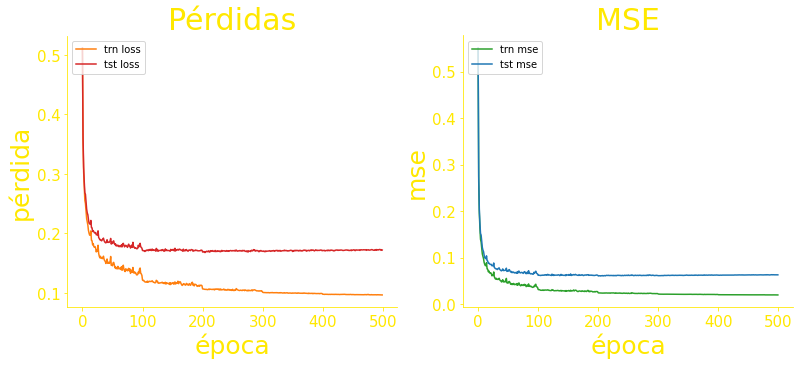

In [18]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns")

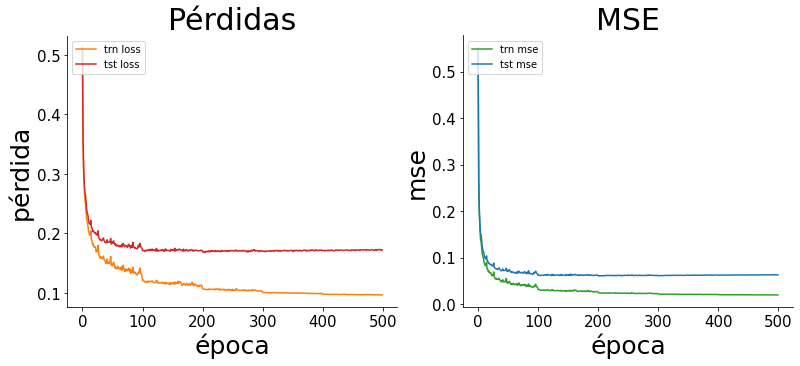

In [19]:
plot_metrics(loss_hist, mse_hist, epoch = epochs, name = f"metrics_{epochs}epochs_ns_black", c = "black")

[Ir a inicio](#Índice) 

## Evaluamos en entrenamiento

In [84]:
model = torch.load("modelos/NS_500epochs")

In [85]:
with torch.no_grad():
    preds = []
    y_trues = []
    for x, y_true in a_loader:
        out = model(x.to(device))
        y_trues.append(y_true)
        preds.append(out.squeeze().cpu())

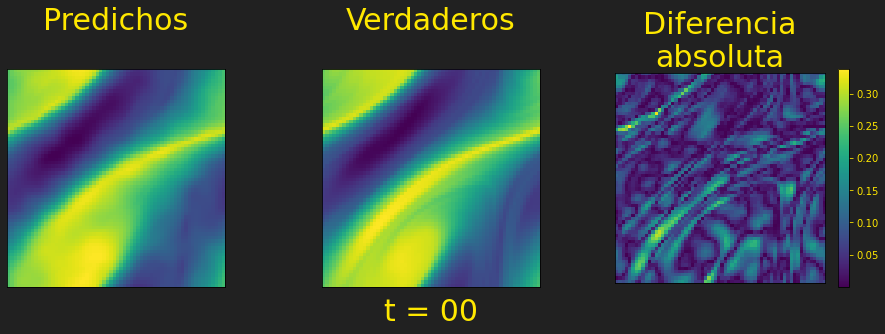

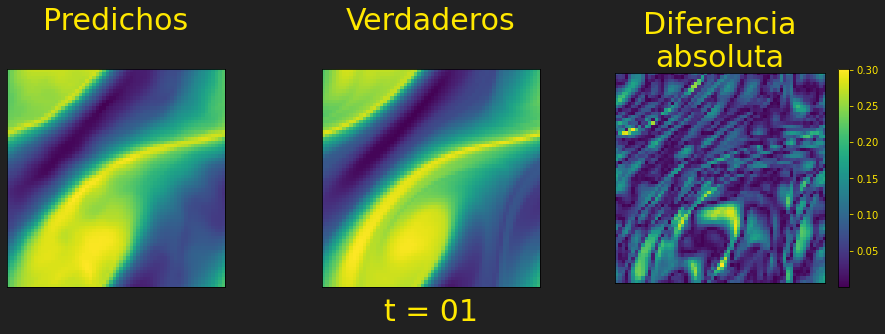

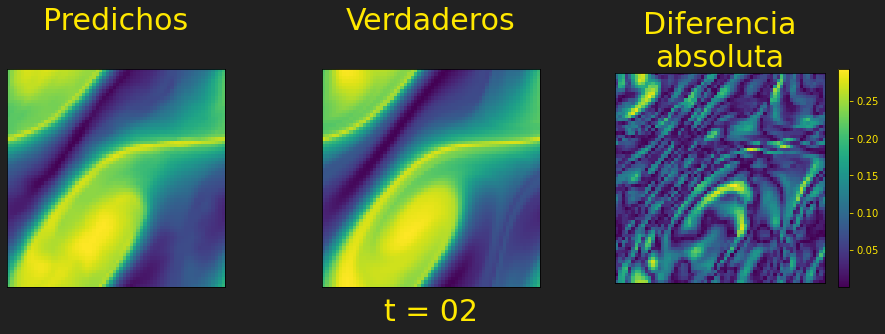

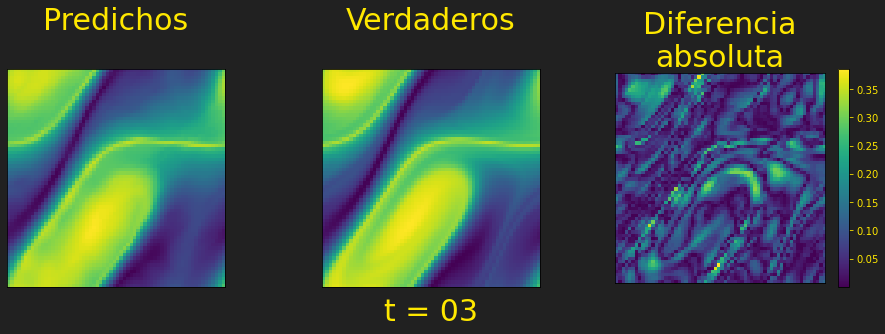

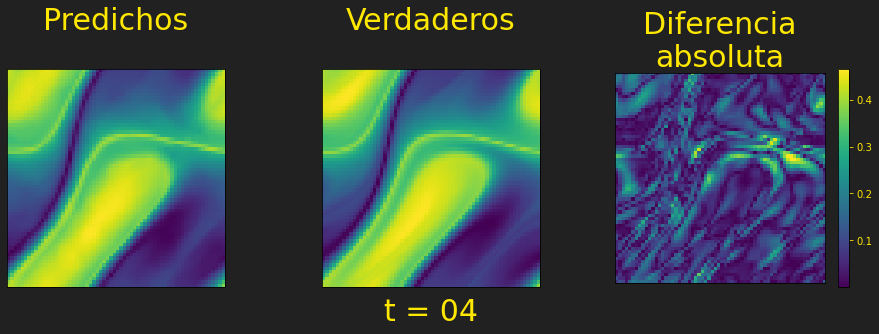

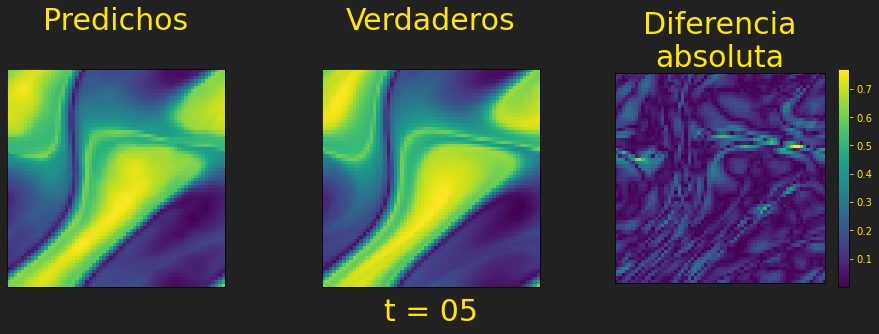

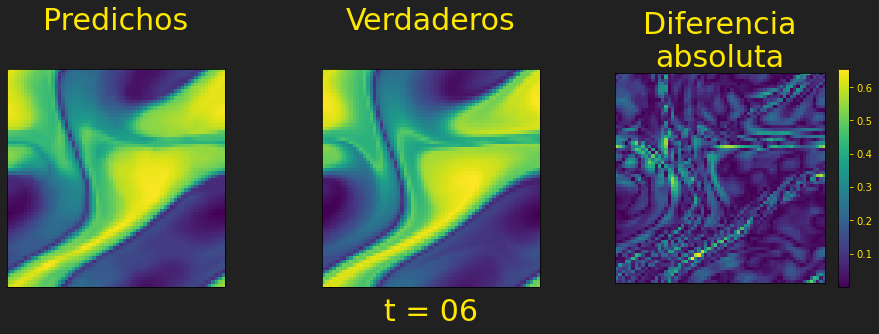

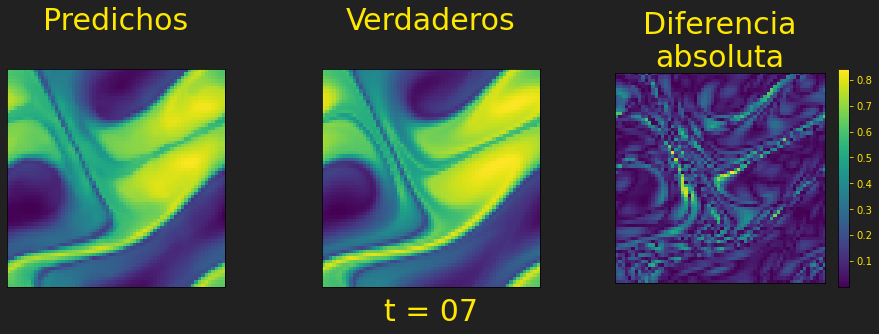

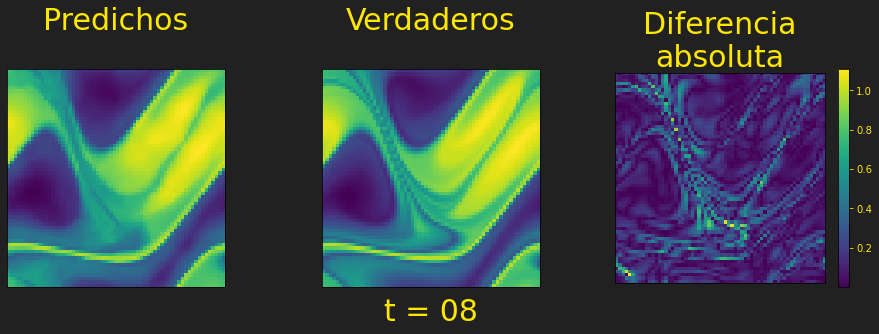

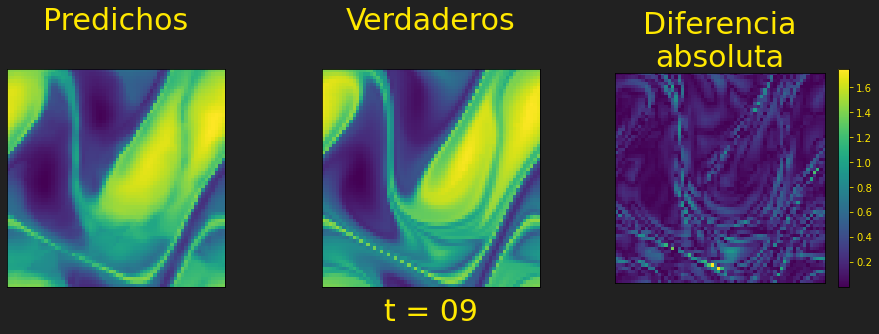

In [86]:
epochs=500
plot_many(preds[0][0,:,:,:], np.array(y_trues[0][0,:,:,:]), epochs)

In [87]:
create_gif(epochs)